In [1]:
import matplotlib.pyplot as plt
import cv2
import os

from process_datasets.augmentation.augmentation import stretch, distort, perspective
from doctr.io import DocumentFile
from doctr.models import detection_predictor
import numpy as np
from copy import deepcopy
import pandas as pd
from typing import List
from sklearn.cluster import DBSCAN

/Users/anastasiabogatenkova/miniconda3/envs/doc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


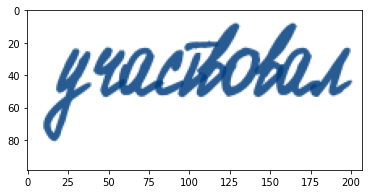

In [2]:
img_name = "datasets/synthetic_raw/img/16_59.png"
im = cv2.imread(img_name)
plt.imshow(im)

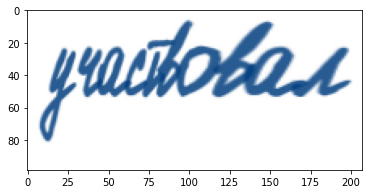

In [3]:
plt.imshow(stretch(stretch(im, 2), 2))

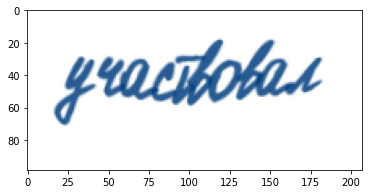

In [4]:
plt.imshow(distort(distort(im, 4), 4))

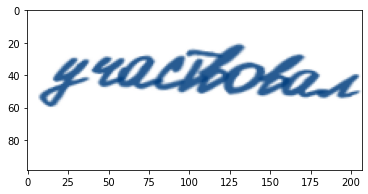

In [5]:
plt.imshow(perspective(perspective(im)))

In [6]:
data_dir = "data/lines_detection"
file_name = "{i}.png"

In [7]:
doc_name = os.path.join(data_dir, file_name.format(i=3))
single_img_doc = DocumentFile.from_images(doc_name)
model = detection_predictor(arch='db_resnet50', pretrained=True).eval()
out = model(single_img_doc)
img = cv2.imread(doc_name)
h, w, _ = img.shape
bboxes = [(int(box[0] * w), int(box[1] * h), int(box[2] * w), int(box[3] * h)) for box in out[0]]

/Users/anastasiabogatenkova/miniconda3/envs/doc/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


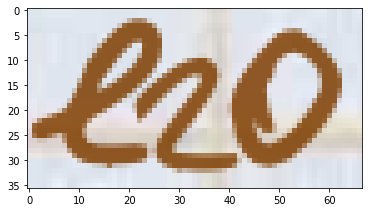

In [8]:
bbox = bboxes[10]
x1, y1, x2, y2 = bbox
cropped_img = deepcopy(img[y1:y2, x1:x2])
plt.imshow(cropped_img)

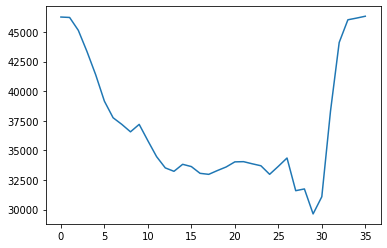

In [9]:
cr_pr = cropped_img.sum(axis=1).sum(axis=1)
plt.plot(cr_pr)

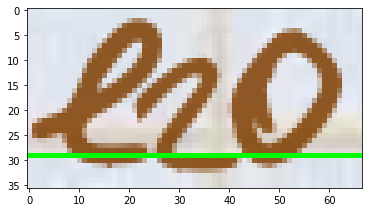

In [10]:
shift = np.argmin(cr_pr)
y1, y2, y1+np.argmin(cr_pr)
im = cv2.line(cropped_img, (0, shift), (cropped_img.shape[1], shift), color=(0, 255, 0))
plt.imshow(im)

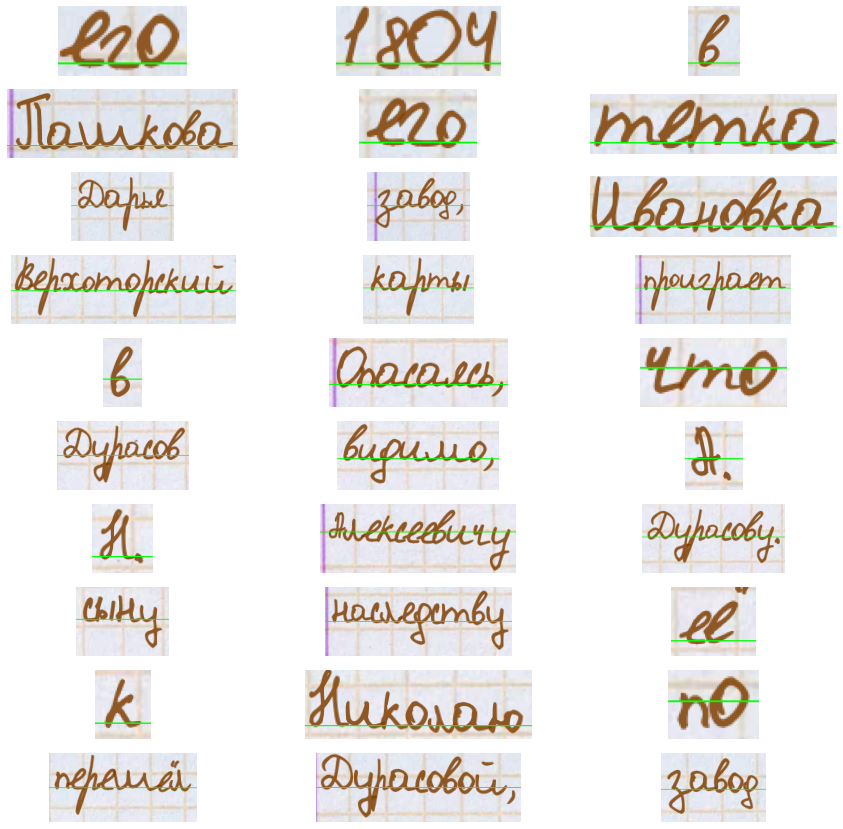

In [11]:
axes_x = 3
axes_y = min(len(bboxes) // 3, 10)
len_axes = axes_x * axes_y
fig, axes = plt.subplots(axes_y, axes_x)
fig.set_figheight(15)
fig.set_figwidth(15)

for i, bbox in enumerate(bboxes[10:]):
    if i >= len_axes:
        break
    x1, y1, x2, y2 = bbox
    im = deepcopy(img[y1:y2, x1:x2])
    cr_pr = im.sum(axis=1).sum(axis=1)
    shift = np.argmin(cr_pr)
    im = cv2.line(im, (0, shift), (im.shape[1], shift), color=(0, 255, 0))
    # axes[i//3,i%3].set_title(f"predicted: {word}")
    axes[i//3,i%3].imshow(im)
    axes[i//3,i%3].axis('off')

In [12]:
img = cv2.imread(os.path.join(data_dir, file_name.format(i=1)))
single_img_doc = DocumentFile.from_images(os.path.join(data_dir, file_name.format(i=1)))
out = model(single_img_doc)
h, w, _ = img.shape
bboxes = [(int(box[0] * w), int(box[1] * h), int(box[2] * w), int(box[3] * h)) for box in out[0]]



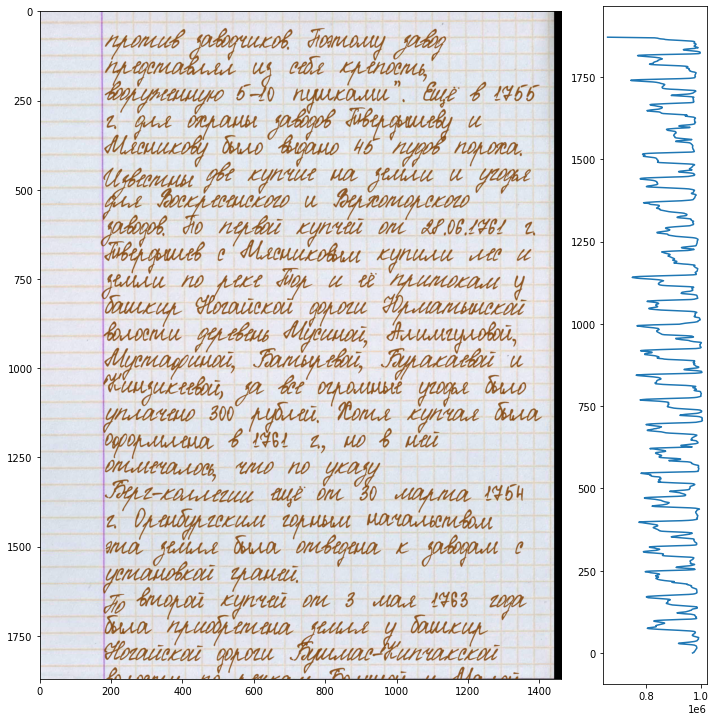

In [13]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]})
fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()

ax[0].imshow(img)
projection = img.sum(axis=1).sum(axis=1)
ax[1].plot(projection,range(len(projection)))

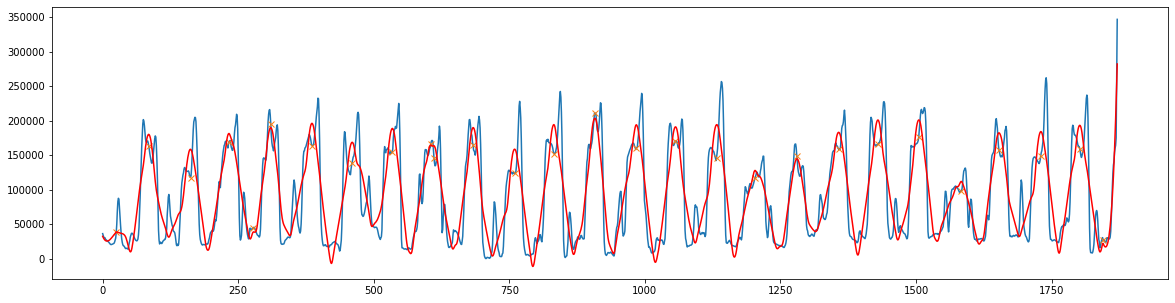

In [14]:
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

x = np.max(projection) - projection
xhat = savgol_filter(x, 51, 3)
peaks, _ = find_peaks(xhat, height=0)
plt.figure(figsize=(20, 5))
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(xhat, color='red')
plt.show()

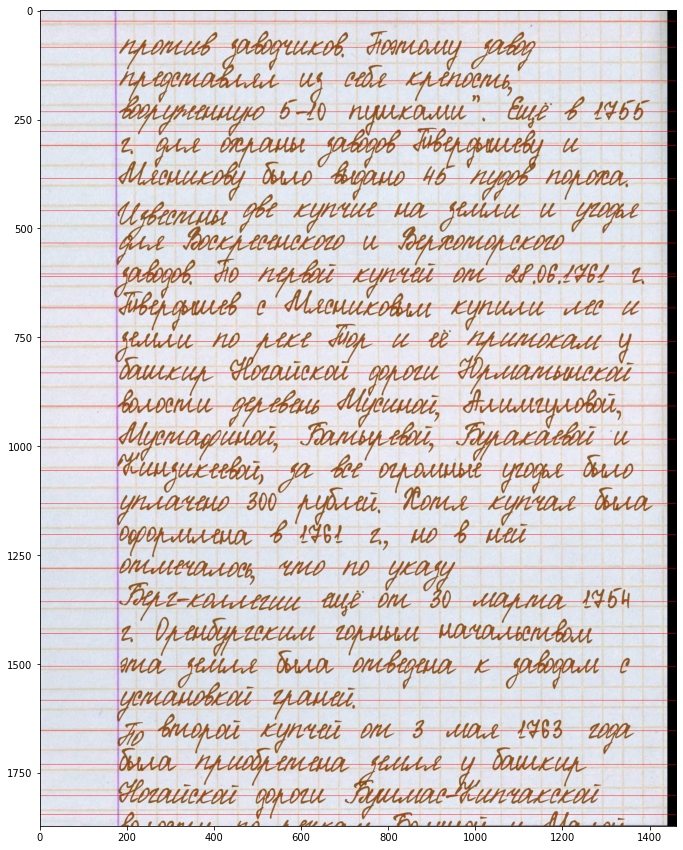

In [15]:
img_with_lines = deepcopy(img)

for idx in peaks:
    cv2.line(img_with_lines, (0, idx), (img_with_lines.shape[1], idx), (255, 0, 0))

plt.figure(figsize=(15, 15))
plt.imshow(img_with_lines)

In [16]:
img = cv2.imread("data/img.png")
pr = img.sum(axis=1).sum(axis=1)
pr = np.max(pr) - pr

In [17]:
y_list = []
y_start = 0

for i, s in enumerate(pr):
    if s != 0:
        continue
    if s == 0 and i > 0 and pr[i - 1] != 0:
        y_start = i
        continue
    if s == 0 and i < len(pr) - 1 and pr[i + 1] != 0 and i - y_start > 10:
        y_list.append((i + y_start) // 2)

y_list.append(len(pr) - 1)

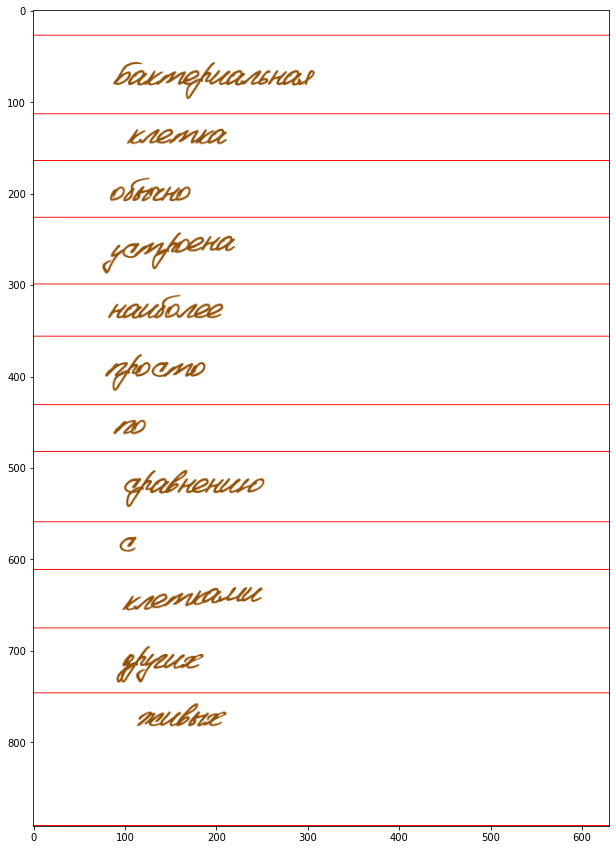

In [18]:
img_with_lines = deepcopy(img)
for y in y_list:
    cv2.line(img_with_lines, (0, y), (img_with_lines.shape[1], y), (255, 0, 0))

plt.figure(figsize=(15, 15))
plt.imshow(img_with_lines)

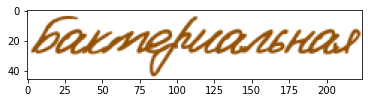

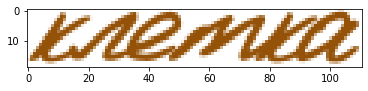

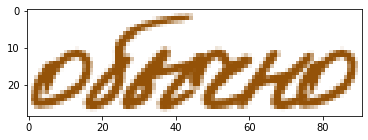

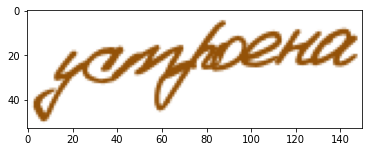

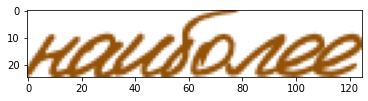

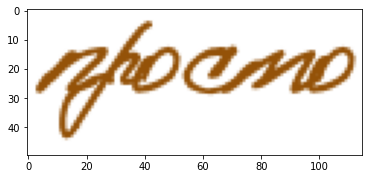

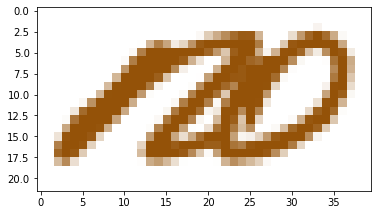

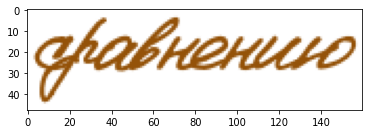

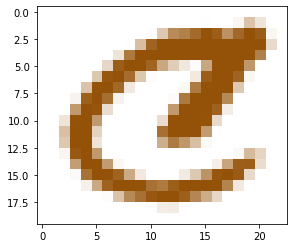

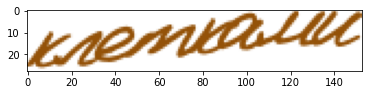

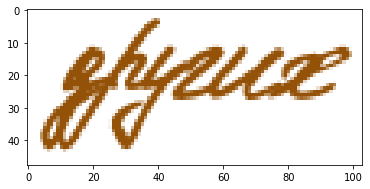

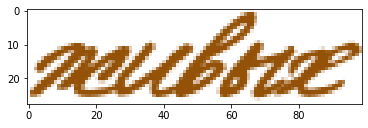

In [19]:
model = detection_predictor(arch='db_resnet50', pretrained=True).eval()

img_copy = deepcopy(img)
out = model([img_copy])

h, w, _ = img_copy.shape
bboxes = [(int(box[0] * w), int(box[1] * h), int(box[2] * w), int(box[3] * h)) for box in out[0]]
bboxes = sorted(bboxes, key=lambda x: x[1])
for bbox in bboxes:
    x1, y1, x2, y2 = bbox
    plt.figure()
    plt.imshow(img_copy[y1:y2, x1:x2])

In [20]:
dataset_dir = os.path.join("datasets", "synthetic_raw")

def show_results(gt_df: pd.DataFrame, n: int = 21):
    df_sample = gt_df.sample(n=n)
    axes_x = 3
    axes_y = min(n // 3, 10)
    len_axes = axes_x * axes_y
    fig, axes = plt.subplots(axes_y, axes_x)
    fig.set_figheight(20)
    fig.set_figwidth(15)

    for i, (ind, row) in enumerate(df_sample.iterrows()):
        if i >= len_axes:
            break
        word = row["word"]
        img_name = os.path.join(dataset_dir, row["path"])
        im = cv2.imread(img_name)
        axes[i//3,i%3].set_title(f"{word}")
        axes[i//3,i%3].imshow(im)
        axes[i//3,i%3].axis('off')

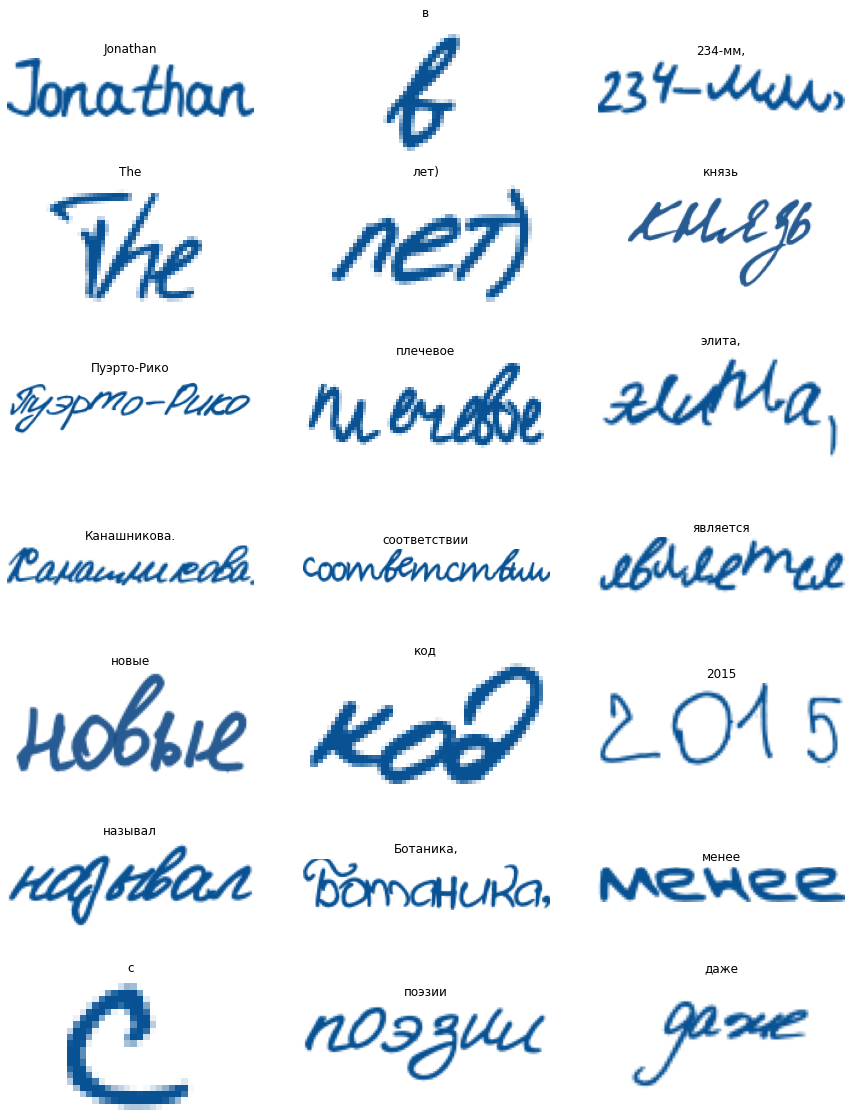

In [21]:
df = pd.read_csv(os.path.join(dataset_dir, f"merged_gt.txt"), sep="\t", names=["path", "word"])
show_results(df)

In [22]:
# dataset_dir = os.path.join("datasets", "synthetic")
# df = pd.read_csv(os.path.join(dataset_dir, f"gt.txt"), sep="\t", names=["path", "word"])
# merged_df = pd.read_csv(os.path.join(dataset_dir, f"merged_gt.txt"), sep="\t", names=["path", "word"])
# df.head()
# df.shape, merged_df.shape
# merged_df = pd.concat([df, merged_df], ignore_index=True)
# merged_df.to_csv(os.path.join(dataset_dir, "merged_gt.txt"), sep="\t", index=False, header=False)
# merged_df.shape

In [23]:
# from htr import HTRReader
# from utils import ModelOptions
#
# opt = ModelOptions(saved_model="saved_models/TPS-ResNet-BiLSTM-Attn-Seed1-Rus-Kz-Synth.pth",
#                    batch_size=1, Prediction="Attn")
# htr_reader = HTRReader(opt)
# import json
#
# os.makedirs("data/result_good_data", exist_ok=True)
#
# data_dir = "data/good_data"
# with open("data/good_data/gt.json") as f:
#     gt = json.load(f)
#
# for file_name in tqdm(os.listdir(data_dir)):
#     if not file_name.endswith(".jpg"):
#         continue
#     doc_path = os.path.join(data_dir, file_name)
#     if file_name in gt:
#         words_str = gt[file_name]
#     else:
#         print(f"{file_name} not found in gt")
#         continue
#
#     # words_list = htr_reader.get_text(doc_path)
#     # words_list = [" ".join(line) for line in words_list]
#     # words_str = "\n".join(words_list)
#     plt.figure(figsize=(10, 10))
#     plt.title(words_str)
#     img = cv2.imread(doc_path)
#     plt.imshow(img)
#     plt.savefig(f"data/result_good_data/{file_name}")

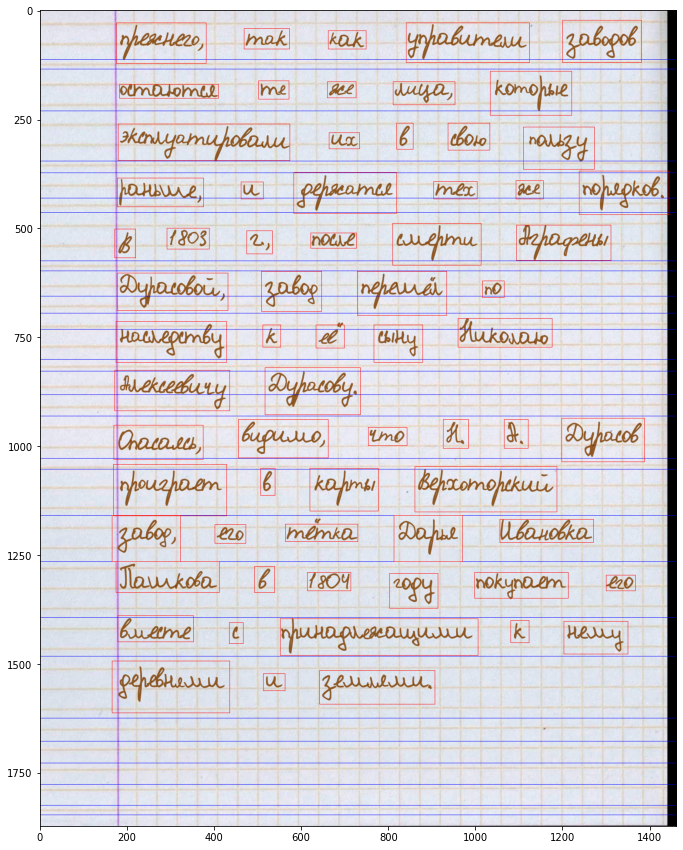

In [24]:
from lines_segmentation.lines_seg_th import recognize_lines

model = detection_predictor(arch='db_resnet50', pretrained=True).eval()
img = cv2.imread("data/lines_detection/3.png")

out = model([img])
h, w, _ = img.shape
bboxes = [(int(box[0] * w), int(box[1] * h), int(box[2] * w), int(box[3] * h)) for box in out[0]]

separators = recognize_lines(img, t=0.3)

for shift in separators:
    img = cv2.line(img, (0, shift), (img.shape[1], shift), color=(0, 0, 255))

for bbox in bboxes:
    x1, y1, x2, y2 = bbox
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0))

plt.figure(figsize=(15, 15))
plt.imshow(img)

True

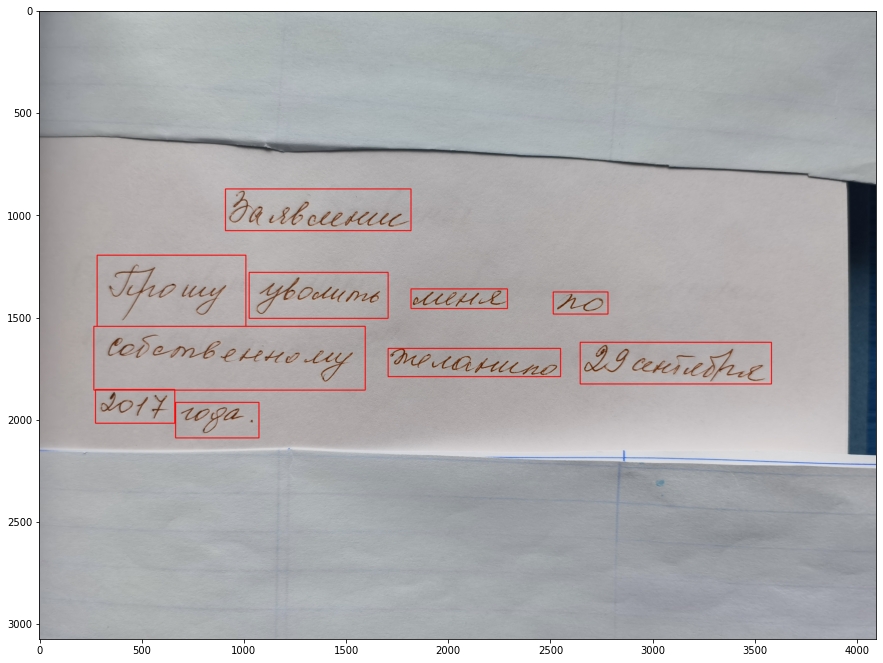

In [25]:
img_path = "data/example/IMG_20220425_142247.jpg"
img = cv2.imread(img_path)
out = model([img])
h, w, _ = img.shape
bboxes = [(int(box[0] * w), int(box[1] * h), int(box[2] * w), int(box[3] * h)) for box in out[0]]

for bbox in bboxes:
    x1, y1, x2, y2 = bbox
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 3)

plt.figure(figsize=(15, 15))
plt.imshow(img)
cv2.imwrite("data/example/with_bboxes.png", img)

In [26]:
for bbox in bboxes:
    x1, y1, x2, y2 = bbox
    cv2.imwrite("data/example/" + str(bbox)+".png", img[y1:y2, x1:x2])

In [27]:
from htr import HTRReader
from utils import ModelOptions

opt = ModelOptions(saved_model="saved_models/TPS-ResNet-BiLSTM-Attn-Seed1-Rus-Kz-Synth.pth",
                   batch_size=1, Prediction="Attn")
htr_reader = HTRReader(opt)
htr_reader.get_text(img_path)

[['Заявление'],
 ['Прошу', 'уволить', 'меня', 'по'],
 ['собственному', 'желанипо', '29снтября'],
 ['2017', 'года.']]

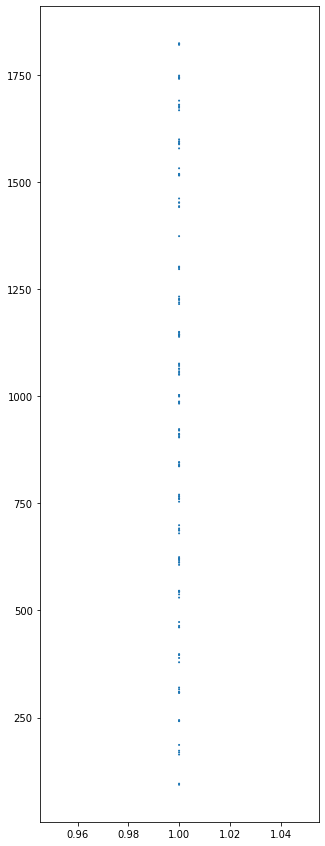

In [28]:
model = detection_predictor(arch='db_resnet50', pretrained=True).eval()
img = cv2.imread("data/lines_detection/2.png")

out = model([img])
h, w, _ = img.shape
bboxes = [(int(box[0] * w), int(box[1] * h), int(box[2] * w), int(box[3] * h)) for box in out[0]]

y_mean_list = []
for bbox in bboxes:
    y1, y2 = bbox[1], bbox[3]
    y_mean_list.append(y1 + (y2 - y1) / 2)

x_list = [1 for _ in y_mean_list]
plt.figure(figsize=(5, 15))
plt.scatter(x_list, y_mean_list, marker='o', sizes=[1 for _ in x_list])

In [29]:
points = [[1, y] for y in y_mean_list]
DBSCAN(min_samples=1, eps=30).fit_predict(points)

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  6,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16,
       16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18,
       19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22,
       22, 22, 22, 23, 23])

In [30]:
clusters = DBSCAN(min_samples=1, eps=30).fit_predict(points)
lines_bboxes = []
prev_cluster = None
for bbox, line_idx in zip(bboxes, clusters):
    if line_idx != prev_cluster:
        prev_cluster = line_idx
        lines_bboxes.append([])
    lines_bboxes[-1].append(bbox)

lines = []
for line_bbox_list in lines_bboxes:
    max_x = max([bbox[2] for bbox in line_bbox_list])
    min_x = min([bbox[0] for bbox in line_bbox_list])
    max_y = max([bbox[3] for bbox in line_bbox_list])
    min_y = min([bbox[1] for bbox in line_bbox_list])
    lines.append((min_x, min_y, max_x, max_y))

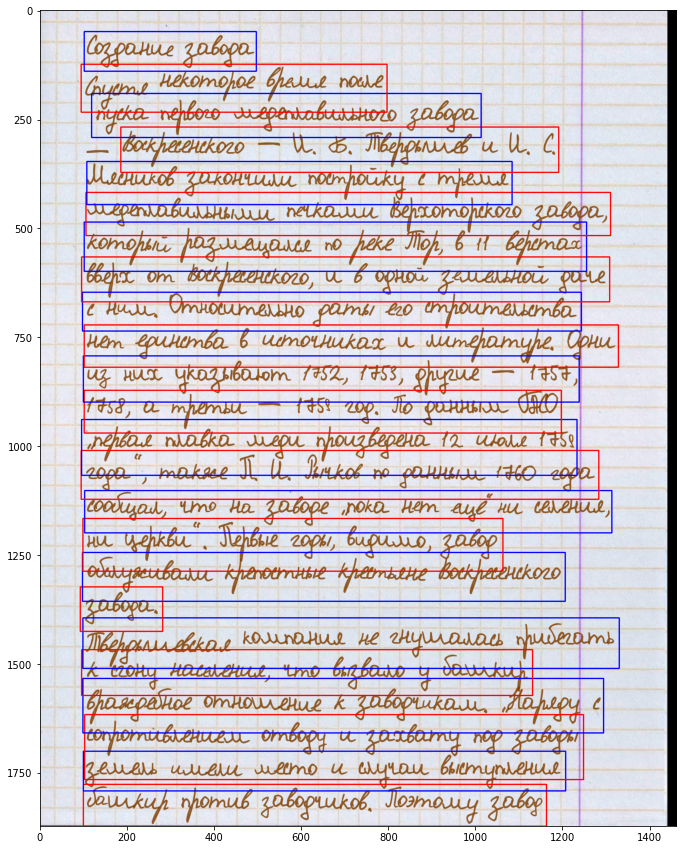

In [31]:
red = True

img_copy = deepcopy(img)
for bbox in lines:
    x1, y1, x2, y2 = bbox
    if red:
        img_copy = cv2.rectangle(img_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)
        red = False
    else:
        img_copy = cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)
        red = True

plt.figure(figsize=(15, 15))
plt.imshow(img_copy)

In [32]:
def cluster_bboxes(bboxes_list: List[tuple]) -> List[tuple]:
    y_mean_list = []
    for bbox in bboxes_list:
        y1, y2 = bbox[1], bbox[3]
        y_mean_list.append(y1 + (y2 - y1) / 2)
    points = [[1, y] for y in y_mean_list]
    clusters = DBSCAN(min_samples=1, eps=30).fit_predict(points)
    lines_bboxes = []
    prev_cluster = None
    for bbox, line_idx in zip(bboxes_list, clusters):
        if line_idx != prev_cluster:
            prev_cluster = line_idx
            lines_bboxes.append([])
        lines_bboxes[-1].append(bbox)
    lines = []
    for line_bbox_list in lines_bboxes:
        max_x = max([bbox[2] for bbox in line_bbox_list])
        min_x = min([bbox[0] for bbox in line_bbox_list])
        max_y = max([bbox[3] for bbox in line_bbox_list])
        min_y = min([bbox[1] for bbox in line_bbox_list])
        lines.append((min_x, min_y, max_x, max_y))
    return lines

model = detection_predictor(arch='db_resnet50', pretrained=True).eval()

def get_bboxes(img_path: str) -> List[tuple]:
    img = cv2.imread(img_path)
    out = model([img])
    h, w, _ = img.shape
    bboxes = [(int(box[0] * w), int(box[1] * h), int(box[2] * w), int(box[3] * h)) for box in out[0]]
    return bboxes

def draw_bboxes(img_path: str, bboxes: List[tuple]) -> np.ndarray:
    img = cv2.imread(img_path)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    return img

def visualise_bboxes(img_path: str, bboxes: List[tuple]) -> np.ndarray:
    red = True
    img = cv2.imread(img_path)
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        if red:
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            red = False
        else:
            img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            red = True

    return img


In [33]:
def visualise(img_path: str) -> None:
    bboxes = get_bboxes(img_path)
    lines_bboxes = cluster_bboxes(bboxes)
    img1 = draw_bboxes(img_path, bboxes)
    img2 = visualise_bboxes(img_path, lines_bboxes)
    fig, ax = plt.subplots(1, 2)
    ax[0].axis('off')
    ax[1].axis('off')
    fig.set_figheight(10)
    fig.set_figwidth(15)
    ax[0].imshow(img1)
    ax[1].imshow(img2)

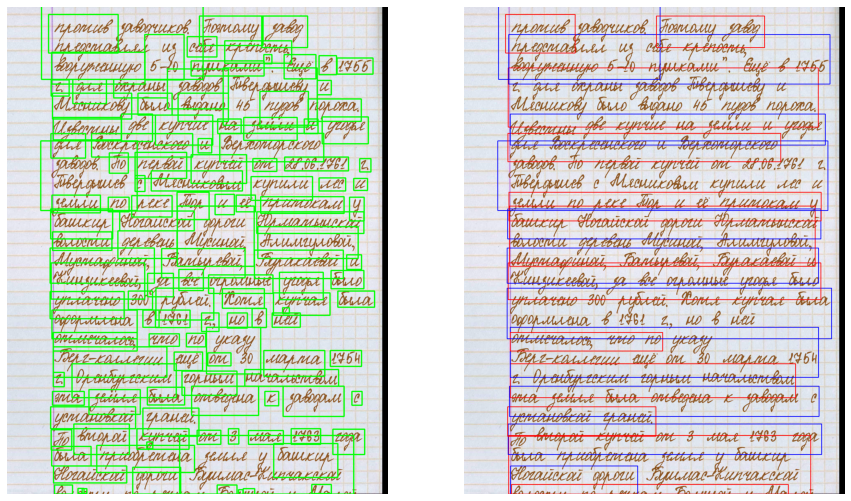

In [34]:
visualise("data/lines_detection/1.png")


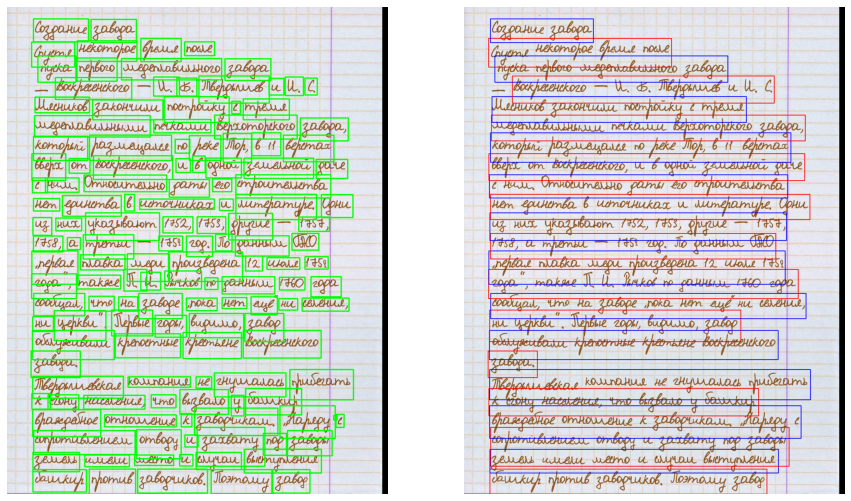

In [35]:
visualise("data/lines_detection/2.png")

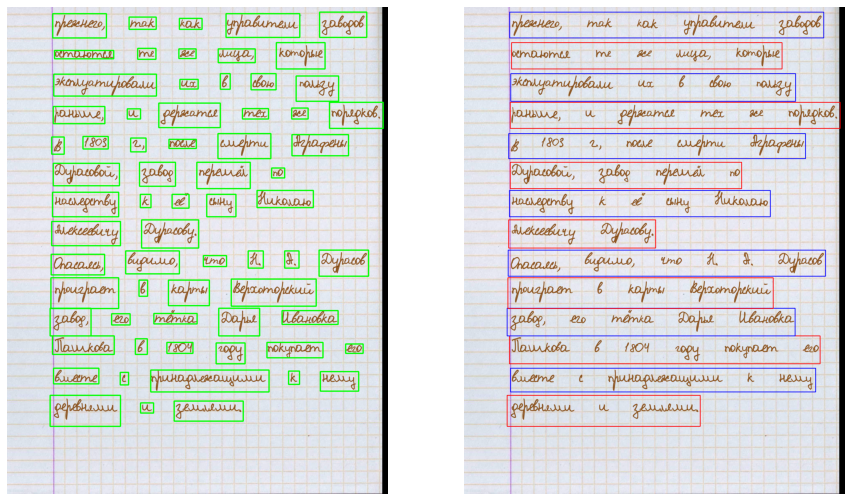

In [36]:
visualise("data/lines_detection/3.png")

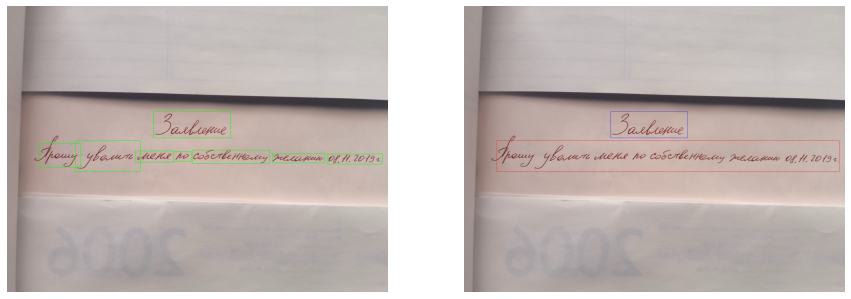

In [37]:
visualise("data/lines_detection/IMG_20220425_122148.jpg")

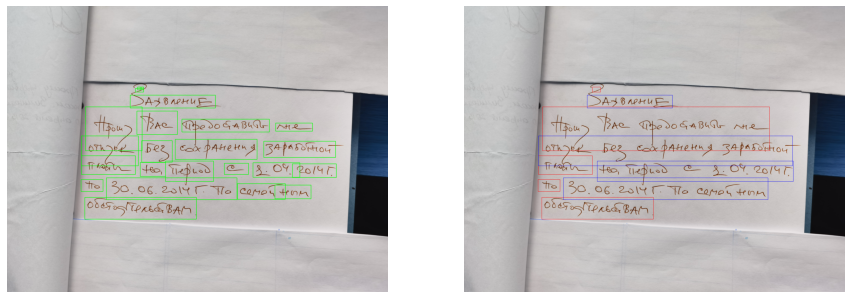

In [38]:
visualise("data/lines_detection/IMG_20220425_125143.jpg")

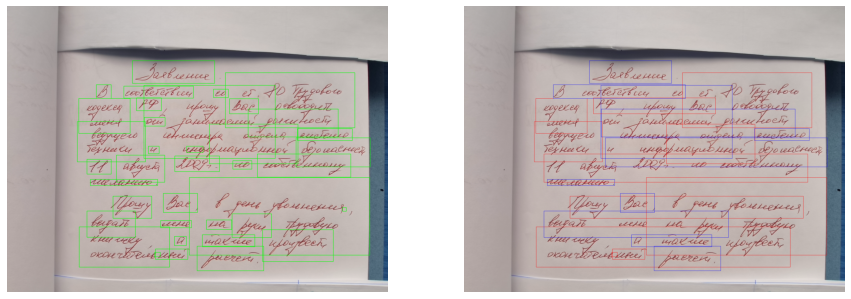

In [39]:
visualise("data/lines_detection/IMG_20220425_131910.jpg")